# COVID-19 Data Analysis with Python - Learn & Talk Tech Surrey

This notebook is adapted from the work of Patrick Sánchez whose notebook can be found here: https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-4), in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19.

**To start - press 'Run All'**

In [ ]:
# Default Kaggle Python 3 environment message

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from scipy import integrate, optimize

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Note: If you do not see any files listed in the output above, please check that you have a folder inside your `input/` folder called `covid19-global-forecasting-week-4/` which contains `train.csv`, `submission.csv` and `test.csv`.** 

If not, you can press `+ Add data` and then add the following competition dataset:

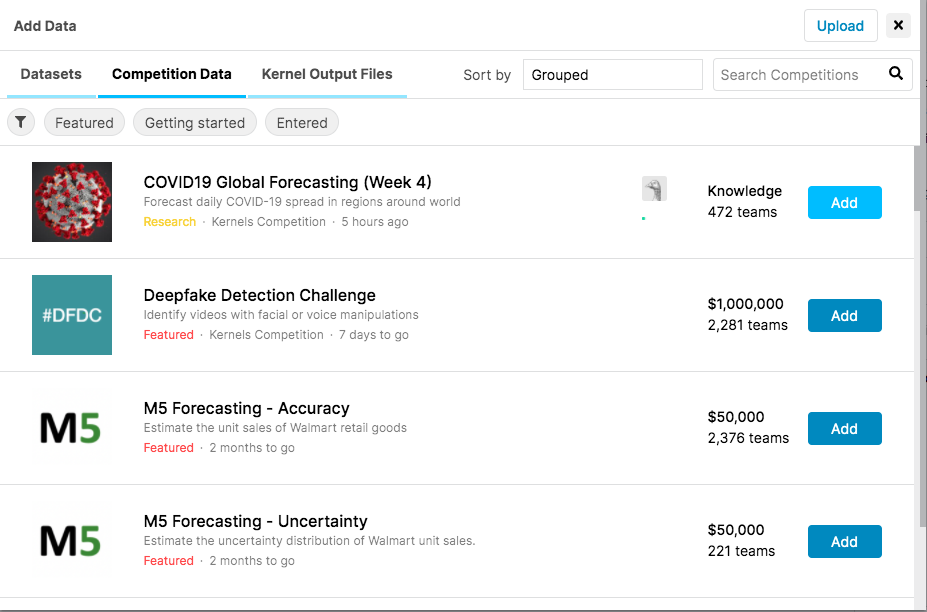

## Workshop Outline

1. Explore the COVID-19 Dataset from John Hopkins University, primarily in terms of **confirmed cases** and **fatalities**
1. Look at global trends including and excluding China
1. Compare select countries like Canada, US, Italy, Spain and South Korea
1. Understand the basic SIR model and Basic Reproduction Number $R_0$
1. Apply and test the SIR model
1. Compare trends to a forecast exponential model
1. Are we flattening the curve? A look at BC vs. other provinces and South Korea
1. Interesting resources


## Explore COVID-19 Global Dataset

### Import the Data

The dataset used here is what powers the John Hopkins University COVID-19 dashboard which you may have seen: https://coronavirus.jhu.edu/map.html

Our data is stored in: `input/covid19data/covid-19_data.csv`. Since this is essentially the **training** data for any of our analysis, we will read this data into a variable called `train`. Let us have a look at this covid-19 training dataset:

1. First, just click on the `covid-19_data.csv` file from the `Data` section in the right-side menu. This will only show us the first 100 rows.
2. Then we use Python to pull in and look at a summary of the data

In [ ]:
# Read in the data
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")

# Fill in empty cells under 'Provice_State'
train.Province_State.fillna("None", inplace=True)

# Display the first 5 rows and provide a summary table
display(train.head(5))
display(train.describe())

# Print some additional stats
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")

So this training dataset contains data from 184 countries and starts from Jan 22, 2020 - when John Hopkins University started to compile daily reports: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports .

Now let us plot worldwide trends for confirmed cases and fatalities:

### Global Trends including and excluding China

In [ ]:
# Aggregate confirmed cases and fatalities across all countries
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})

overall_total_date = confirmed_total_date.join(fatalities_total_date)

# Plot both confirmed and fatalities together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
overall_total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

# Plot just the fatalities
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: The global curve numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact, the criteria to consider confirmed infection cases was modified around 2020-02-11 as seen in the figure.

Now let us look at these same curves **without China**:

In [ ]:
# Exclude China in our training data plots
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
overall_total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

# Plot both confirmed and fatalities together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
overall_total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

# Plot just the fatalities
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf) which we get into shortly.

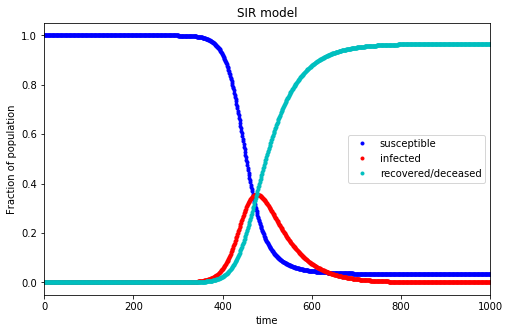

### COVID-19 Trends - Only China

Since China is the initially infected country, the COVID-19 behavior is different from the rest of the world. Awareness of the virus did not become mainstream until the government started to acknowledge its existance and then took strong, sometimes contentious, measures in a very short amount of time to control the increasing number of infections.

Let us look at the training dataset for only China:

In [ ]:
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
overall_total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

# Plot confirmed and fatalities together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
overall_total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

# Plot fatalities only
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China fatalities", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

We see confirmed cases and fatalities trend lines flattening out, indicating a plateau of infections and deaths. We also see some choppy data due to changes in reporting methodologies. But we see how the curve flattens, which is what every country is currently trying to do.  

The global and China specific trends give us a sense of the current trends, and **a glimpse into what we want to get our national trendline of confirmed cases and deaths to look like - i.e. "flattening the curve".** 

Now, let us look at the dataset of some specific countries.

### COVID-19 Datasets: Canada, US, Italy, Spain, South Korea

We will start by taking a look at these specific countries because of the amount of discussion in the media about them, specifically:

* Italy & Spain - rapid rise in cases and deaths. At one point, Italy was the global epicenter of the pandemic
* US - currently the global epicenter of the pandemic and significantly higher cases and even deaths than any other country
* South Korea - deemed a model for other countries to follow. See https://www.youtube.com/watch?v=BE-cA4UK07c 


#### Exercise:
The following code is provided for Italy, Spain and South Korea. **Use it as a guide to generate similar graphs for Canada and the US:**

In [ ]:
# Italy
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

# Spain 
confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

# South Korea
confirmed_total_date_KOR = train[train['Country_Region']=='Korea, South'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_KOR = train[train['Country_Region']=='Korea, South'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_KOR = confirmed_total_date_KOR.join(fatalities_total_date_KOR)

# TODO: Add Canada
confirmed_total_date_Canada = train[train['Country_Region']=='Canada'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Canada = train[train['Country_Region']=='Canada'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Canada = confirmed_total_date_Canada.join(fatalities_total_date_Canada)

# TODO: Add US
confirmed_total_date_US = train[train['Country_Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US = train[train['Country_Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)



# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

# Plot the confirmed totals together
ax1.plot(confirmed_total_date_Italy, label='Italy')
ax1.plot(confirmed_total_date_Spain, label='Spain')
ax1.plot(confirmed_total_date_KOR, label='South Korea')
ax1.plot(confirmed_total_date_Canada, label='Canada')
ax1.plot(confirmed_total_date_US, label='US')

ax1.set_title("Confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
ax1.legend(loc="upper left")


# Plot the fatalities totals together
ax2.plot(fatalities_total_date_Italy, label='Italy')
ax2.plot(fatalities_total_date_Spain, label='Spain')
ax2.plot(fatalities_total_date_KOR, label='South Korea')
ax2.plot(fatalities_total_date_Canada, label='Canada')
ax2.plot(fatalities_total_date_US, label='US')

ax2.set_title("Fatalities", size=13)
ax2.set_ylabel("Number of fatalities", size=13)
ax2.set_xlabel("Date", size=13)
ax2.legend(loc="upper left")

Now let us look at these same graphs with the x-axis being the number of days since the **first confirmed case** (or since Jan 22, 2020) to gauge how fast or slow health authorities were to act:

In [ ]:
# Italy since first confirmed case
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

# Spain since first confirmed case
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

# South Korea since first confirmed case
confirmed_total_date_KOR = train[(train['Country_Region']=='Korea, South') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_KOR = train[(train['Country_Region']=='Korea, South') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_KOR = confirmed_total_date_KOR.join(fatalities_total_date_KOR)

# Canada since first confirmed case
confirmed_total_date_Canada = train[(train['Country_Region']=='Canada') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Canada = train[(train['Country_Region']=='Canada') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Canada = confirmed_total_date_Canada.join(fatalities_total_date_Canada)

# US since first confirmed case
confirmed_total_date_US = train[(train['Country_Region']=='US') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US = train[(train['Country_Region']=='US') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)


# Extract 'Confirmed Cases' list and remove timestamps
italy_confirmed = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
spain_confirmed = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
kor_confirmed = [i for i in total_date_KOR.ConfirmedCases['sum'].values]
canada_confirmed =[i for i in total_date_Canada.ConfirmedCases['sum'].values]
us_confirmed = [i for i in total_date_US.ConfirmedCases['sum'].values]

# Extract 'Fatalities' list and remove timestamps
italy_fatalities = [i for i in total_date_Italy.Fatalities['sum'].values]
spain_fatalities = [i for i in total_date_Spain.Fatalities['sum'].values]
kor_fatalities = [i for i in total_date_KOR.Fatalities['sum'].values]
canada_fatalities = [i for i in total_date_Canada.Fatalities['sum'].values]
us_fatalities = [i for i in total_date_US.Fatalities['sum'].values]


# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

# Plot the confirmed totals together
ax1.plot(italy_confirmed, label='Italy')
ax1.plot(spain_confirmed, label='Spain')
ax1.plot(kor_confirmed, label='South Korea')
ax1.plot(canada_confirmed, label='Canada')
ax1.plot(us_confirmed, label='US')

ax1.set_title("Total COVID-19 infections from the first confirmed case", size=13)
ax1.set_ylabel("Infected cases", size=13)
ax1.set_xlabel("Days", size=13)
ax1.legend(loc="upper left")


# Plot the fatalities totals together
ax2.plot(italy_fatalities, label='Italy')
ax2.plot(spain_fatalities, label='Singapore')
ax2.plot(kor_fatalities, label='Korea')
ax2.plot(canada_fatalities, label='Canada')
ax2.plot(us_fatalities, label='US')

ax2.set_title("Total COVID-19 fatalities from the first confirmed case", size=13)
ax2.set_ylabel("Number of fatalities", size=13)
ax2.set_xlabel("Days", size=13)
ax2.legend(loc="upper left")

What observations can you make from these graphs w.r.t:

* Italy vs Spain?
* The response in the US?
* The response in Canada?

#### Total Confirmed Cases as a Fraction of Population

Next, let us plot the total confirmed cases for Canada, US, Italy, Spain and South Korea taking into account the population of each of those countries:

In [ ]:
pop_italy = 60461826.
pop_spain = 46754778.
pop_korea = 51269185.
pop_canada = 37742154.
pop_us = 331002651.


frac_Italy_ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
frac_Spain_ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
frac_KOR_ConfirmedCases = total_date_KOR.ConfirmedCases/pop_korea*100.

frac_Canada_ConfirmedCases = total_date_Canada.ConfirmedCases/pop_canada*100.
frac_US_ConfirmedCases = total_date_US.ConfirmedCases/pop_us*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
frac_Italy_ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction % of population infected")
plt.ylim(0, 0.5)

plt.subplot(2, 3, 2)
frac_Spain_ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.5)

plt.subplot(2, 3, 3)
frac_KOR_ConfirmedCases.plot(ax=plt.gca(), title='South Korea')
plt.ylim(0, 0.5)

plt.subplot(2, 3, 4)
frac_Canada_ConfirmedCases.plot(ax=plt.gca(), title='Canada')
plt.ylim(0, 0.5)

plt.subplot(2, 3, 5)
frac_US_ConfirmedCases.plot(ax=plt.gca(), title='US')
plt.ylim(0, 0.5)

These plots using the fraction of the population infected lead us to look at the COVID-19 data using a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf)

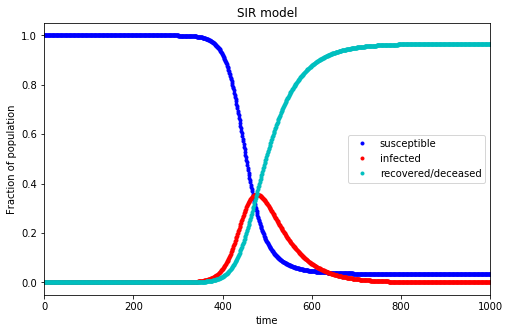

### The SIR model

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model which add additional details such as considering birth and death (SIRD with demography), and other intermediate states. We are keeping things simple so that if you are interested, you can then later explore some of the more complicated variants of the SIR model.

The differential equations that govern the system are: (for a quick easy to understand review on differential equations in biology, see https://www.youtube.com/watch?v=IYFkXWlgC_w) 

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where: 
* $\beta$ is a parameter controlling how much the disease can be transmitted through exposure. It is determined by the chance of contact and the probability of disease transmission. Behaviours such as social distancing, hand-washing, and central gatherings affect this parameter. 

* $\gamma$ is the recovery rate or how much the disease can be recovered in a specific period. If $d$ is the average days to recover from the infection, $$d = {1 \over \gamma} $$

This leads us to the much discussed **basic reproduction number**. 

#### Basic Reproduction Number: $R_0$

$R_0$ is the average number of people infected from one other person. Estimated mean values of $R_0$ for well known diseases are (source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118/):

* Smallpox in Indian subcont. (1968–73) - 4.5
* Poliomyelitis in Europe (1955–60) - 6
* Measles in Ghana (1960–68) - 14.5
* SARS epidemic in (2002–03) - 3.5
* 1918 Spanish influenza in Geneva
     * Spring wave - 1.5	
     * Fall wave - 3.8
* H2N2 influenza pandemic in US (1957) - 1.68
* H1N1 influenza in South Africa (2009) - 1.33
* Ebola in Guinea (2014) - 1.51
* Zika in South America (2015–16) - 2.06

Estimating the $R_0$ of COVID-19 is a work in progress and still early days. Analysis of data from Wuhan suggests an **estimated $R_0$ of 3.5** (source: https://pubmed.ncbi.nlm.nih.gov/32125128/)

$$R_0 = {\beta \over \gamma} = {\beta * d}$$

Using available preliminary data, the median time from onset to clinical recovery for mild cases is approximately 2 weeks and is 3-6 weeks for patients with severe or critical disease (https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)

If we take $R_0 = 3.5$ and $d = 14$, our $\beta$ parameter for disease transmission is $0.25$. 

Now let us try and implement the SIR model using these parameters.

### Implementing the SIR Model

This involves a bunch of math and numerical methods to solve those differential equations from above. Don't worry, we won't be covering this so you can safely go ahead and execute this next code block. Some details are provided if you do want to get into the mathematical details on your own. 

In [ ]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

# Runge-Kutta method of 4th order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.
    hs = 0.1

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

So let us look at this SIR model with the following **initial conditions** and parameters:

* N = world population
* Start with only 1 initially infected case
* $\beta=0.25$
* $recovery\_days = 14$

In [ ]:
# User input parameters for the model
N = 7800*(10**6)
beta = 0.1
recovery_days = 28

# Other set parameters
b0 = 0
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, 1/recovery_days, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,5000)
plt.savefig('SIR_example.png')
plt.show()

How does the infected proportion change if:

* Length of recovery_days doubles? Halves?
* Transmission rate  β doubles? Halves

Notice how different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the effect on the model.

### Fit the SIR Model to real data

Let us try and fit the theoretical SIR model to Canada's confirmed cases curve:

In [ ]:
# Fraction of population confirmed cases
frac_Canada_ConfirmedCases = total_date_Canada.ConfirmedCases/pop_canada*100.
canada_confirmed = [i for i in frac_Canada_ConfirmedCases['sum'].values]

# Number of days since first confirmed case
num_days = list(range(1,len(canada_confirmed) + 1))

# Input parameters of the model
N = 37*(10**6)
beta = 0.25
recovery_days = 14

# Defined parameters
b0 = 0
hs = 0.1
gamma = 1 / recovery_days

# Create the model
sus, inf, rec = SIR(N, b0, beta, gamma, hs)

ydata = np.array(canada_confirmed, dtype=float)
xdata = np.array(num_days, dtype=float)

inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

# Fit the data to the model
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)


# Plot the result
plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Canada infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1], " and recovery_days = ", 1/popt[1])


How do the theoretical beta and recovery_days numbers from the SIR model match the real world?

The first part of the SIR model infection curve resembles exponential growth. Let us now compare how well Canada's confirmed cases currently resemble exponential growth.

### Projections - Are we seeing exponential growth?

The following code creates a best-fit exponential curve to the data and plots both curves. It also allows us to specify how many of the last X days to exclude to allow us to compare the exponential trendline to the actual data.

In [ ]:
import scipy
import seaborn as sns
def plot_exponential_fit_data(d_df, title, delta):
    d_df = d_df.sort_values(by=['Date'], ascending=True)
    d_df['x'] = np.arange(len(d_df)) + 1
    d_df['y'] = d_df['sum']

    x = d_df['x'][:-delta]
    y = d_df['y'][:-delta]

    c2 = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(40, 0.1))
    #y = Ae^(Bx)
    A, B = c2[0]
    print(f'(y = Ae^(Bx)) A: {A}, B: {B}')
    x = range(1,d_df.shape[0] + 1)
    y_fit = A * np.exp(B * x)
    size = 3
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.scatterplot(x=d_df['x'][:-delta], y=d_df['y'][:-delta], label='Confirmed cases (included for fit)', color='red')
    g = sns.scatterplot(x=d_df['x'][-delta:], y=d_df['y'][-delta:], label='Confirmed cases (validation)', color='blue')
    g = sns.lineplot(x=x, y=y_fit, label='Predicted values', color='green')
    plt.xlabel('Days since first case')
    plt.ylabel(f'cases')
    plt.title(f'Confirmed cases & predicted evolution: {title}')
    plt.xticks(rotation=90)
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show()

Now, let us plot the graph of total confirmed cases in Canada and **exclude the last 10 days**:

In [ ]:
# Plot excluding the last 10 days
plot_exponential_fit_data(total_date_Canada.ConfirmedCases, 'Canada', 10)

What if we look at just the last 5 days? or 15 days? Have we avoided exponential growth in confirmed cases?

### Is BC flattening the curve? Comparison with other provinces

Let's now look at the data for BC vs. Quebec and Ontario - both which seem to have been hit harder by COVID-19. We will also use South Korea data as our benchmark for flattening the curve. 

In [ ]:
# South Korea since first confirmed case
confirmed_total_date_KOR = train[(train['Country_Region']=='Korea, South') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_KOR = train[(train['Country_Region']=='Korea, South') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_KOR = confirmed_total_date_KOR.join(fatalities_total_date_KOR)

# BC confirmed cases and fatalities
confirmed_total_date_BC = train[(train['Country_Region']=='Canada') & (train['Province_State']=='British Columbia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_BC = train[(train['Country_Region']=='Canada') & (train['Province_State']=='British Columbia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_BC= confirmed_total_date_BC.join(fatalities_total_date_BC)

# Quebec confirmed cases and fatalities
confirmed_total_date_QC = train[(train['Country_Region']=='Canada') & (train['Province_State']=='Quebec') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_QC = train[(train['Country_Region']=='Canada') & (train['Province_State']=='Quebec') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_QC= confirmed_total_date_QC.join(fatalities_total_date_QC)

# Ontario confirmed cases and fatalities
confirmed_total_date_ON = train[(train['Country_Region']=='Canada') & (train['Province_State']=='Ontario') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_ON = train[(train['Country_Region']=='Canada') & (train['Province_State']=='Ontario') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_ON= confirmed_total_date_ON.join(fatalities_total_date_ON)

In [ ]:
# Extract 'Confirmed Cases' list and remove timestamps

bc_confirmed = [i for i in total_date_BC.ConfirmedCases['sum'].values]
qc_confirmed = [i for i in total_date_QC.ConfirmedCases['sum'].values]
on_confirmed = [i for i in total_date_ON.ConfirmedCases['sum'].values]
kor_confirmed = [i for i in total_date_KOR.ConfirmedCases['sum'].values]

# Extract 'Fatalities' list and remove timestamps
bc_fatalities = [i for i in total_date_BC.Fatalities['sum'].values]
qc_fatalities = [i for i in total_date_QC.Fatalities['sum'].values]
on_fatalities = [i for i in total_date_ON.Fatalities['sum'].values]
kor_fatalities = [i for i in total_date_KOR.Fatalities['sum'].values]


# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

# Plot the confirmed totals together
ax1.plot(bc_confirmed, label='BC')
ax1.plot(qc_confirmed, label='Quebec')
ax1.plot(on_confirmed, label='Ontario')
ax1.plot(kor_confirmed, label='South Korea')

ax1.set_title("Total COVID-19 infections from the first confirmed case", size=13)
ax1.set_ylabel("Infected cases", size=13)
ax1.set_xlabel("Days", size=13)
ax1.legend(loc="upper left")


# Plot the fatalities totals together
ax2.plot(bc_fatalities, label='BC')
ax2.plot(qc_fatalities, label='Quebec')
ax2.plot(on_fatalities, label='Ontario')
ax2.plot(kor_fatalities, label='Korea')

ax2.set_title("Total COVID-19 fatalities from the first confirmed case", size=13)
ax2.set_ylabel("Number of fatalities", size=13)
ax2.set_xlabel("Days", size=13)
ax2.legend(loc="upper left")

So how do you think BC is doing compared to other provinces? Try to add some other provinces (e.g. Alberta) to see how they are doing compared to BC.

### Additional things to try

We covered a lot here! Some things to try on your own with this notebook copy are:

* Look at other countries of interest: Iran, India, UK, Germany
* Which countries have higher % of their populations infected and how do they relate to the SIR model?
* Copy and run other COVID-19 Kaggle notebooks with interesting forecast models - https://www.kaggle.com/c/covid19-global-forecasting-week-4

### Interesting Resources

* Simulating an epidemic video - https://www.youtube.com/watch?v=gxAaO2rsdIs&t=519s
* BC Center for Disease Control daily reports - http://www.bccdc.ca/health-info/diseases-conditions/covid-19/case-counts-press-statements
* Coronavirus and Data Privacy - https://www.youtube.com/watch?v=k5OAjnveyJo